In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import tinyarray

# Testing kwant

## Building tight binding systems and compute conductance

In [2]:
syst = kwant.Builder()

# Make a square lattice
a = 1
lat = kwant.lattice.square(a, norbs=1)

# Define the scattering region
width, length = 10, 20
t = 1.0 # energy constant
syst[(lat(l, w) for l in range(length) for w in range(width))] = 4 * t
syst[lat.neighbors()] = -t

# manipulating boundary conditions
# adding leads in the x direction (translational symmetry in x)
translational_sym = kwant.TranslationalSymmetry((-a, 0))

# define a symmetric edge
sym_edge = kwant.Builder(translational_sym)

# define the scattering region
sym_edge[(lat(0, w) for w in range(width))] = 4 * t
sym_edge[lat.neighbors()] = -t

        

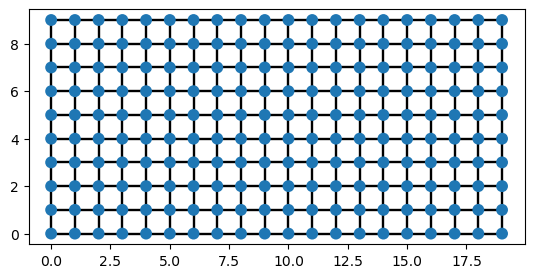

In [3]:
# plot the system
kwant.plot(syst)
plt.show()

In [4]:
syst_np = syst.finalized()

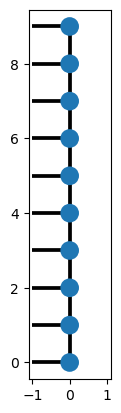

In [5]:
kwant.plot(sym_edge)
plt.show()

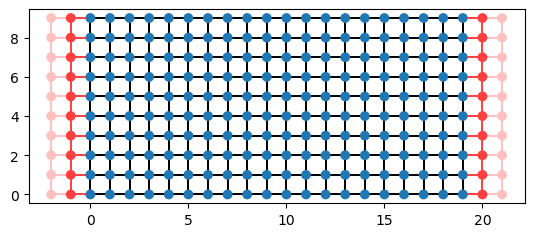

In [6]:
# leads are attached to calculate the transmission between them using the scattering matrix, we have two leads (0, 1)
syst.attach_lead(sym_edge)
syst.attach_lead(sym_edge.reversed())
kwant.plot(syst)
plt.show()

In [7]:
# finalize the system
syst_p = syst.finalized()

In [39]:
conductance1 = []
conductance = []
energies = np.linspace(0, 2, 100)
for E in energies:
    conductance.append(kwant.smatrix(syst_p, E).transmission(1, 0))
    conductance1.append(kwant.smatrix(syst_p, E).transmission(0, 1))

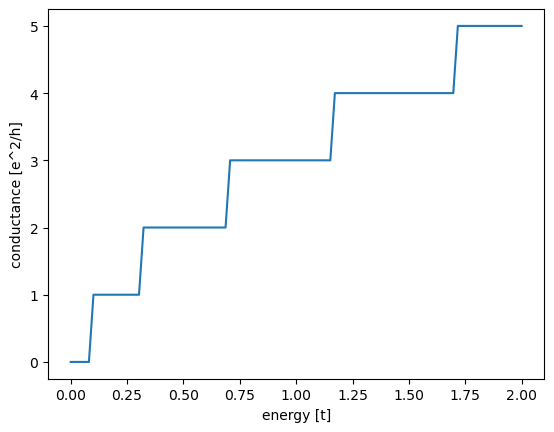

In [40]:
plt.figure()
plt.plot(energies, conductance)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

## More leads

In [41]:
# Attach leads above and below the scattering region
# Define the leads
lead_up = kwant.Builder(kwant.TranslationalSymmetry((0, -a)))
lead_up[(lat(l, 0) for l in range(length))] = 4 * t
lead_up[lat.neighbors()] = -t

lead_down =lead_up.reversed()

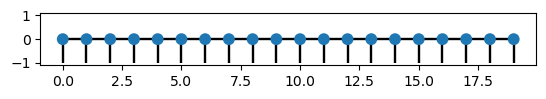

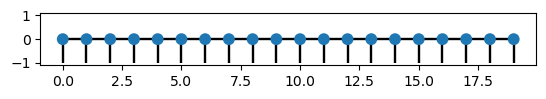

In [42]:
kwant.plot(lead_up)

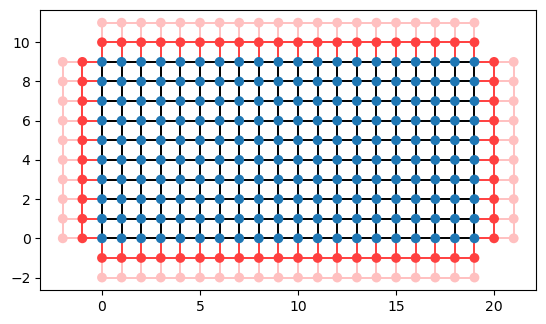

In [43]:
# Attach the leads to the scattering region
syst.attach_lead(lead_up) # lead 2
syst.attach_lead(lead_down) # lead 3
kwant.plot(syst)
plt.show()

In [44]:
# Finalize the system
syst_p2D = syst.finalized()

In [45]:
# calculate the conductance
conductance_vert = []
conductance_hor = []

energies = np.linspace(0, 2, 100)
for E in energies:
    conductance_vert.append(kwant.smatrix(syst_p2D, E).transmission(0, 1))
    conductance_hor.append(kwant.smatrix(syst_p2D, E).transmission(2, 3))

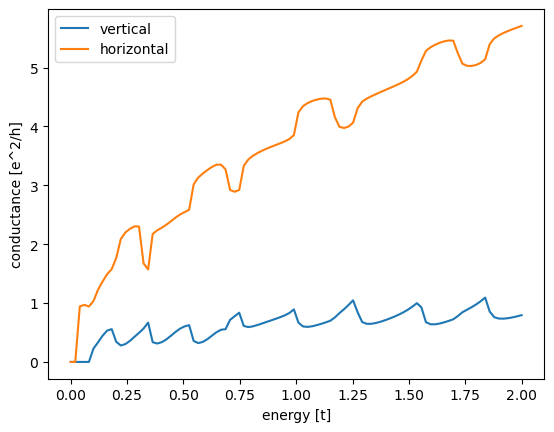

In [46]:
plt.figure()
plt.plot(energies, conductance_vert, label="vertical")
plt.plot(energies, conductance_hor, label="horizontal")
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.legend()
plt.show()

## Hamiltonians and eigenenrgies

In [47]:
# calculate the conductance using sparse matrix
sparse_ham = syst_np.hamiltonian_submatrix(sparse=True)
sparse_ham_p = syst_p.hamiltonian_submatrix(sparse=True)
energies_np = sla.eigs(sparse_ham, k=200 - 2, which='SM', return_eigenvectors=False)
energies_p = sla.eigs(sparse_ham_p, k=200 - 2, which='SM', return_eigenvectors=False)

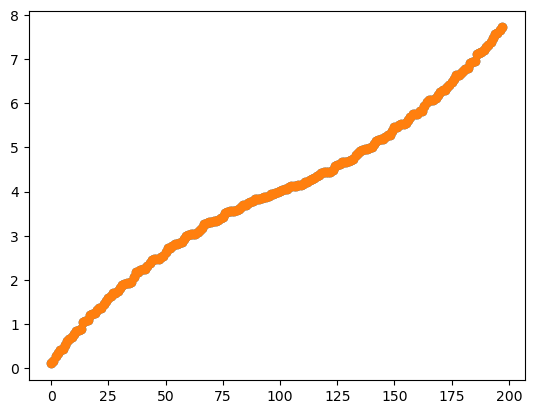

In [48]:
plt.plot(np.sort(np.real(energies_np)), 'o')
plt.plot(np.sort(np.real(energies_p)), 'o')
plt.show()

In [49]:
energies_np, eigenstates = sla.eigs(sparse_ham, k=200 - 2, which='SM')

In [53]:
eigenstates = eigenstates.T

<Figure size 640x480 with 0 Axes>

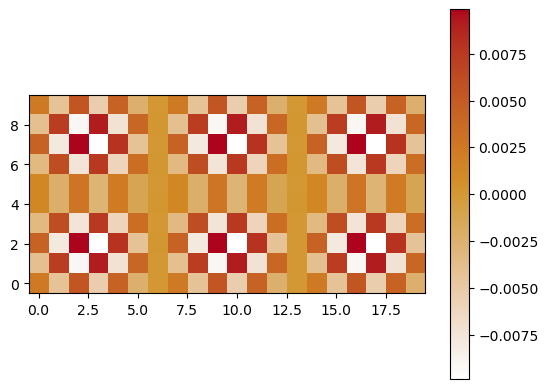

In [70]:
# plot the eigenstates
# they should be plotted on the lattice
def plot_eigenstate(i, prob = False):
    plt.figure()
    if prob:
        kwant.plotter.map(syst_np, np.abs(eigenstates[i])**2)
    else:
        kwant.plotter.map(syst_np, np.real(eigenstates[i]))
    plt.show()
plot_eigenstate(10)

## reset

In [71]:
%reset

# Spin coupling stuff in Kwant

## Rashba Hamiltonian

We will use the Rashba Hamiltonian to describe the spin-orbit coupling in the system. The Rashba Hamiltonian is given by

$$
H = -\frac{\hbar ^2}{2m}\nabla^2  + \hat V(\mathbf{r}) + \alpha (\hat p_y \sigma_x - \hat p_x\sigma_y) + E_z \sigma_z
$$


In [36]:
# define Pauli-matrices for convenience
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [37]:
t = 1.0
alpha = 1.0
e_z = 0.08
W, L = 10, 30

In [38]:
kwant.builder.HoppingKind((1, 0), lat, lat)

HoppingKind((1, 0), kwant.lattice.Monatomic([[1.0, 0.0], [0.0, 1.0]], [0.0, 0.0], '', None))

In [39]:
syst = kwant.Builder()
lat = kwant.lattice.square()
# Define the scattering region, the onsites are only affected by the electric field and the origional onsite terms (4t)
syst[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t * sigma_0 + e_z * sigma_z
syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t * sigma_0 + 1j * alpha * sigma_y/2
syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = -t * sigma_0 - 1j * alpha * sigma_x/2
# adding the spin orbit coupling terms


/home/khaled-hasan/miniconda3/lib/python3.10/site-packages/kwant/lattice.py:746: KwantDeprecationWarning:

Not specfying norbs is deprecated. Always specify norbs when creating site families.



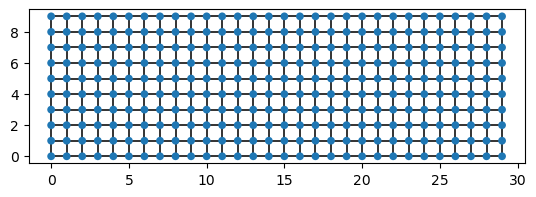

In [40]:
kwant.plot(syst)
plt.show()

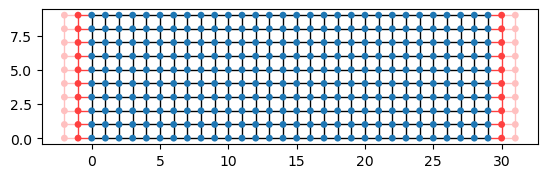

In [41]:
# Attach leads to the scattering region
sym_edge = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
sym_edge[(lat(0, y) for y in range(W))] = 4 * t * sigma_0 + e_z * sigma_z
sym_edge[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t * sigma_0 + 1j * alpha * sigma_y/2
sym_edge[kwant.builder.HoppingKind((0, 1), lat, lat)] = -t * sigma_0 - 1j * alpha * sigma_x/2
# plotting
syst.attach_lead(sym_edge)
syst.attach_lead(sym_edge.reversed())
kwant.plot(syst)
plt.show()

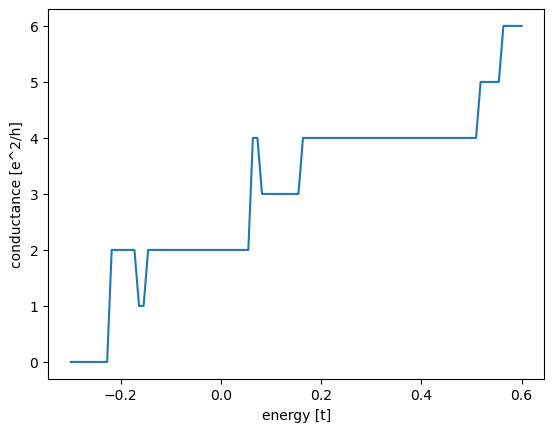

In [45]:
# plot conductance
syst_cond_calc = syst.finalized()
conductance = []
energies = np.linspace(-0.3, 0.6, 100)
for E in energies:
    conductance.append(kwant.smatrix(syst_cond_calc, E).transmission(1, 0))
plt.figure()
plt.plot(energies, conductance)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

# Potential Well

In [47]:
# So the challenge is that the potential is space dependent

W, L, L_well = 10, 30, 10

def potential(site, pot):
    (x, y) = site.pos
    if (L - L_well) / 2 < x < (L + L_well) / 2:
        return pot
    else:
        return 0
    
# this will be the onsite potential, it will not appear in the hopping terms

In [49]:
a, t=1, 1.0
onsite = lambda site, pot: 4*t + potential(site, pot)

system_well = kwant.Builder()
lat = kwant.lattice.square(a, norbs=1)
system_well[(lat(x, y) for x in range(L) for y in range(W))] = onsite # builder allows functions to be passed as onsite
system_well[lat.neighbors(n=1)] = -t

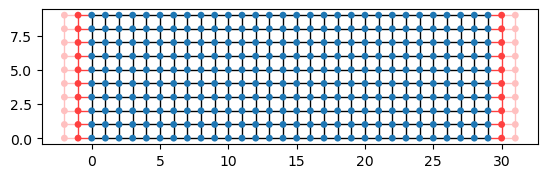

In [50]:
# Attach leads to the scattering region
sym_edge = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
sym_edge[(lat(0, y) for y in range(W))] = 4*t
sym_edge[lat.neighbors()] = -t
system_well.attach_lead(sym_edge)
system_well.attach_lead(sym_edge.reversed())
kwant.plot(system_well)
plt.show()

In [51]:
# it seems like we can still finilize despite not yet having a value for the potential
system_well_finalized = system_well.finalized()

In [52]:
def plot_conducatence(sys, en=1.0, depths=np.linspace(0., 1., 100)):
    cond = []
    for well_depth in depths:
        cond.append(kwant.smatrix(sys, en, params=dict(pot = -well_depth)).transmission(1, 0))
    plt.figure()
    plt.plot(depths, cond)
    plt.xlabel("well depth [t]")
    plt.ylabel("conductance [e^2/h]")
    plt.show()

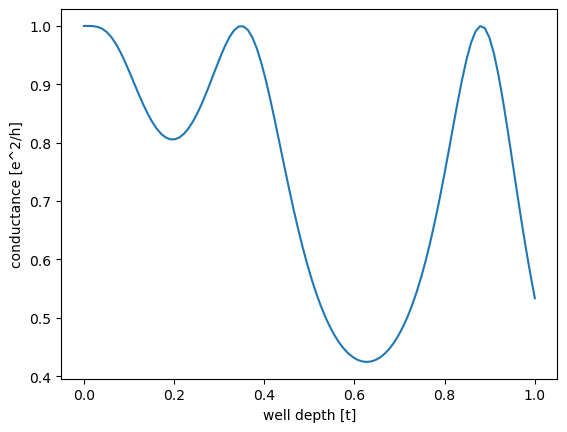

In [59]:
plot_conducatence(system_well_finalized, en=.2)

# An interesting system (Quantum Superconducting interferometry thingy)

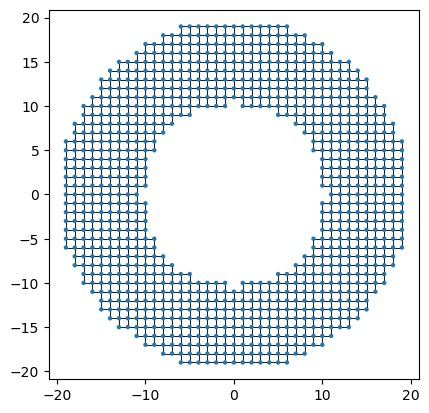

In [56]:
# the system is basicallt a ring, with magnetic flux piercing through it
# define the ring (a boolean characteristic function)
def ring(pos, rin=10, rout=20):
    (x, y) = pos
    return rin**2 < x**2 + y**2 < rout**2

# define the lattice
a = 1
t = 1.0
lat = kwant.lattice.square(a, norbs=1)
# define the system
syst_ring = kwant.Builder()
syst_ring[lat.shape(ring, (0, 11))] = 4 * t
syst_ring[lat.neighbors()] = -t
kwant.plot(syst_ring)
plt.show()

In [57]:
# The onsite terms are not affected by the magnetic flux
# we modify hopping terms be adding terms dependant on the magnetic flux
# The magnetic phase is given by the Peierls Substitution
# t -> t * exp(-i * phi), where phi = integral of A dot dl
# dl = a, B = Bz * z, A = Bz \hat x (x = 0, y < 0)
# it can be confirmed that this gauge will give the same flux (as far as int A .dl)
# is concerned, the flux will also be 0 inside the system (so it is only in the hole)
# this might have been the reason why my other gauge (A = x Bz \hat y) failed 
def hopping(site1, site2, phi):
    return -t * np.exp(1j * phi)

# yield the hopping term
def hops_with_phase(system):
    # make sure you get the line where the vector potential is defined
    for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(system):
        if hop[0].tag[0] == 1 and hop[0].tag[1] < 0: yield hop 
    # for hop in kwant.HoppingKind((0, 1), lat, lat)(system):
    #     yield hop


syst_ring[hops_with_phase] = hopping

In [58]:
W = 10

sym_lead = kwant.TranslationalSymmetry((-a, 0))
lead = kwant.Builder(sym_lead)


def lead_shape(pos):
    (x, y) = pos
    return (-W / 2 < y < W / 2)

lead[lat.shape(lead_shape, (0, 0))] = 4 * t
lead[lat.neighbors()] = -t

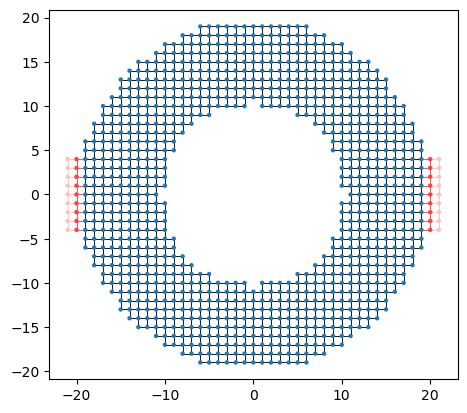

In [59]:
syst_ring.attach_lead(lead)
syst_ring.attach_lead(lead.reversed())
kwant.plot(syst_ring)
plt.show()

In [60]:
def plot_conductance_ring(sys, en=0.2, phi_vals=np.linspace(0, 3*2*np.pi, 3*100)):
    cond = []
    for phi in phi_vals:
        cond.append(kwant.smatrix(sys, en, params=dict(phi=phi)).transmission(1, 0))
    plt.figure()
    plt.plot(phi_vals, cond)
    plt.xlabel("flux")
    plt.ylabel("conductance [e^2/h]")
    plt.show()

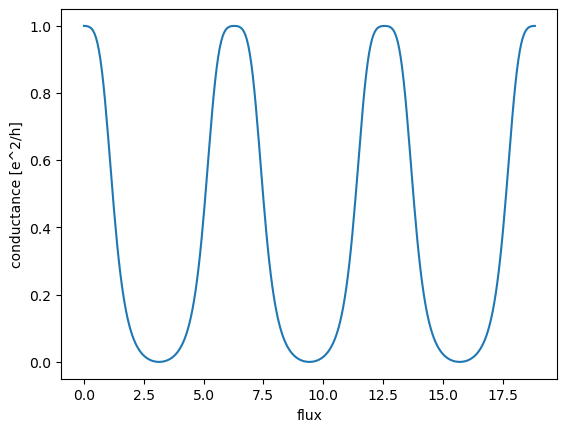

In [65]:
plot_conductance_ring(syst_ring.finalized(), en=0.15)

In the gauge where the whole system was subject to $B_z$ the peaks were far more separated

# Energy Bands

In [70]:
# define a simple lattice
def make_lead(a=1, w = 10, t = 1.0):
    lat = kwant.lattice.square(a, norbs=1)
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, y) for y in range(w))] = 4*t
    lead[lat.neighbors(n=1)] = -t
    return lead


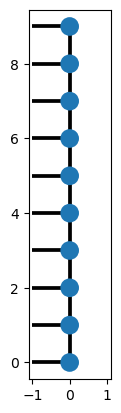

In [73]:
kwant.plot(make_lead())
plt.show()

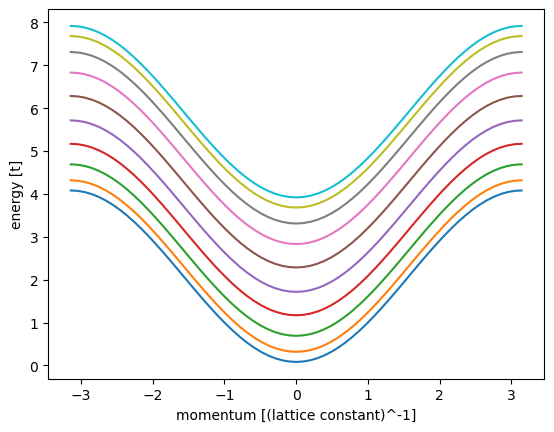

In [ ]:
kwant.plotter.bands(make_lead().finalized(), show=False)
plt.xlabel("momentum [(lattice constant)^-1]")
plt.ylabel("energy [t]")
plt.show()

So the bands are not to be calculated for the finite confined systems, because they do not make sense that way, they are only relavent for the infinite systems cases

# Circular Quantum Dot

In [55]:
def circ_quantum_dot(r, a=1.0, t=1.0):
    lat = kwant.lattice.square(a=a, norbs=1.0)
    quantum_dot = kwant.Builder()
    def circle(pos):
        x, y = pos
        return x*x + y*y < r*r
    quantum_dot[lat.shape(circle, (0, 0))] = 4*t
    # add a penetrating uniform magnetic field
    def get_xhoppings():
        for hop in kwant.HoppingKind((1, 0), lat, lat)(quantum_dot):
            yield hop
    def get_yhoppings():
        for hop in kwant.HoppingKind((0, 1), lat, lat)(quantum_dot):
            yield hop
    # define the gauge using A = x B_z \hat y
    # phi_x = 0
    # phi_y = x B_z a # x should remain constant
    def hoppings_x(site0, site1): return t
    def hoppings_y(site0, site1, B0):
        if not np.allclose(site0.pos[0], site1.pos[0]): raise KeyError("hopping not in x")
        phi_x = site0.pos[0] * a * B0
        return np.exp(1j*phi_x)*t
    quantum_dot[get_xhoppings()] = hoppings_x
    quantum_dot[get_yhoppings()] = hoppings_y
    kwant.plot(quantum_dot)
    plt.show()
    return quantum_dot


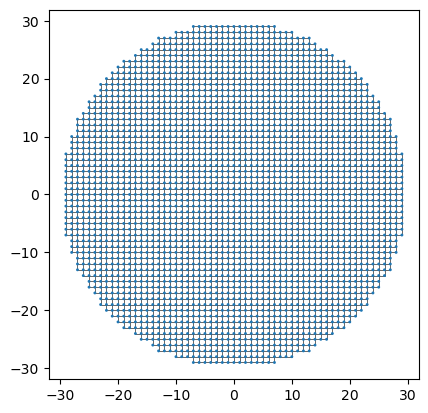

In [56]:
qd1 = circ_quantum_dot(30).finalized()

In [57]:
def plot_energies(num_eigenstates, Bs, Bsystem: kwant.builder.FiniteSystem):
    es = []
    for B0 in Bs:
        Ham = Bsystem.hamiltonian_submatrix(params=dict(B0=B0), sparse=True)
        energies = sla.eigsh(Ham.tocsc(), k=num_eigenstates, sigma=0, return_eigenvectors=False)
        es.append(energies)
    plt.figure()
    plt.plot(Bs, es)
    plt.xlabel(r"$B$")
    plt.ylabel(r"$E$")

In [58]:
plot_energies(15, np.linspace(0, 0.2, 100), qd1)

KeyboardInterrupt: 

In [59]:
spm = qd1.hamiltonian_submatrix(params=dict(B0=0.1), sparse=True)
spm.shape[0]

2809

In [60]:
def plot_eigenstates(system: kwant.builder.FiniteSystem, n: int, B0: float = 0.01, probability = False):
    h = system.hamiltonian_submatrix(params = dict(B0 = B0), sparse = True)
    eigenenergies, eigenstates = sla.eigsh(h.tocsc(), min(n+10, h.shape[0]-1), sigma=0, return_eigenvectors=True)
    targ = eigenstates.T[n]
    if probability: targ = np.abs(targ)**2
    plt.figure()
    kwant.plotter.map(system, targ, oversampling=1, colorbar=True, show=False)
    plt.title(f"Eigenvalue: {eigenenergies[n]:.3f}")
    plt.show()

In [ ]:
def plot_eigencurrents(system: kwant.builder.FiniteSystem, n: int, B0: float = 0.01):
    h = system.hamiltonian_submatrix(params = dict(B0 = B0), sparse = True)
    eigenenergies, eigenstates = sla.eigsh(h.tocsc(), min(n+10, h.shape[0]-1), sigma=0, return_eigenvectors=True)
    targ = eigenstates.T[n]
    J = kwant.operator.Current(system)
    current = J(targ, params=dict(B0=B0))
    kwant.plotter.current(system, current, colorbar=False)
    plt.show()

<Figure size 640x480 with 0 Axes>

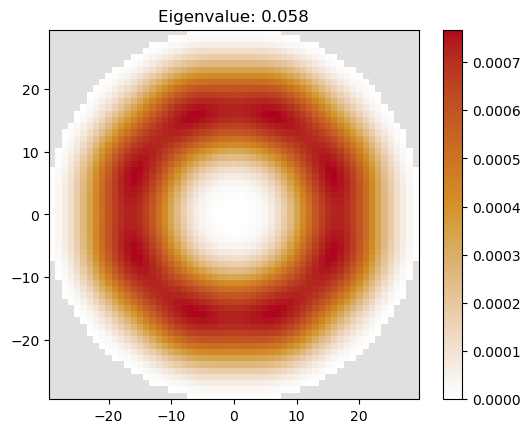

In [62]:
plot_eigenstates(qd1, 9, probability=True)

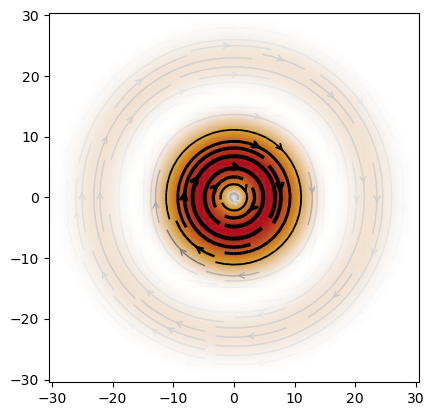

In [64]:
plot_eigencurrents(qd1, 9, B0=0.001)

In [ ]:
def make_graphene_triang_lattice(size=10):
    lat = kwant.lattice.honeycomb(a=1, norbs=1)
    a, b = lat.sublattices  # A and B sublattices

    # Define the triangular region using a function
    def triangular_shape(pos):
        x, y = pos
        return y >= -np.sqrt(3) * x and y >= np.sqrt(3) * (x - size)

    # Build the system
    sys = kwant.Builder()

    # Add nearest-neighbor hoppings (graphene hopping term)
    t = -1  # Hopping amplitude (set to 1 for now)
    for site in sys.sites():
        for neighbor in lat.neighbors():
            if neighbor in sys:
                sys[site, neighbor] = t

    return sys

# Create the system
size = 10  # Control the triangle size
sys = make_graphene_triang_lattice(size)



In [14]:
kwant.lattice.honeycomb(a=1, norbs=10).neighbors()

[HoppingKind((0, 1), kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.0], '0', 10), kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], '1', 10)),
 HoppingKind((0, 0), kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.0], '0', 10), kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], '1', 10)),
 HoppingKind((-1, 1), kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.0], '0', 10), kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], '1', 10))]

In [15]:
def disk(pos):
    x, y = pos
    return x**2 + y**2 < 8**2

lat = kwant.lattice.honeycomb()
syst = kwant.Builder()
syst[lat.shape(disk, (0, 0))] = 0
syst[lat.neighbors()] = -1

/home/khaled-hasan/myenv/lib/python3.12/site-packages/kwant/lattice.py:120: KwantDeprecationWarning:

Not specfying norbs is deprecated. Always specify norbs when creating site families.



In [23]:
lat = kwant.lattice.honeycomb(norbs=1)
a, b = lat.sublattices

def make_system(r=8, t=-1, tp=-0.1):

    def circle(pos):
        x, y = pos
        return x**2 + y**2 < r**2

    syst = kwant.Builder()
    syst[lat.shape(circle, (0, 0))] = 0
    syst[lat.neighbors()] = t
    syst.eradicate_dangling()
    if tp:
        syst[lat.neighbors(1)] = tp

    return syst

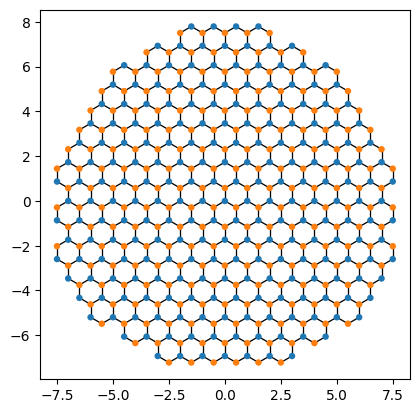

In [24]:
syst = make_system()
kwant.plot(syst)
plt.Circle((0, 0), 8, color='r', fill=False)
plt.show()

In [25]:
import scipy.linalg as la

syst = make_system(tp=0).finalized()
ham = syst.hamiltonian_submatrix()
evecs = la.eigh(ham)[1]

wf = abs(evecs[:, 225])**2

/tmp/ipykernel_177715/512261204.py:1: RuntimeWarning:

The plotted data contains 1.69% of values overflowing upper limit 0.0280641 



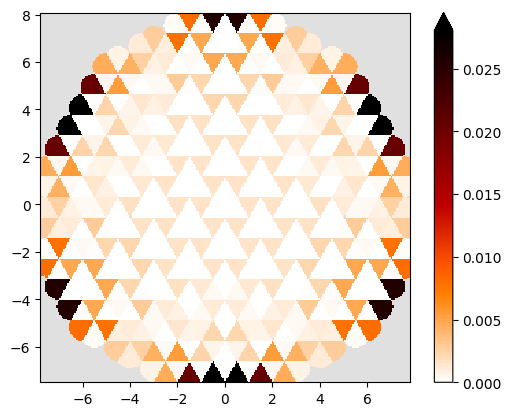

In [26]:
kwant.plotter.map(syst, wf, oversampling=10, cmap='gist_heat_r');